In [361]:
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time 
from scipy.signal import convolve2d
from math import comb

In [362]:
def get_img_mat(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return img_array

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array


In [378]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Function '{func.__name__}' took {duration:.6f} seconds to run.")
        return result
    return wrapper


def expand_image(img, expanded_size, kernel_size=5, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights/4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0]*ratio:ratio, :img.shape[1]*ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


#create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n-1, i) * comb(n-1, j)
    
    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)
    
    return kernel, kernel_factor

    


def reduce_image(img, reduced_img_size, kernel_size = 5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))
    
    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]
    
    return reduced_img



def get_reduced_size(img, factor=2):
    return (img.shape[0]//factor, img.shape[1]//factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1])))-1

# @measure_time
def create_pyramid(img, kernel_size=5):
    pyramid = []
    pyramid.append({'G' : img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i-1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})
        
    for i in range(len(pyramid)-1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i+1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid

def plot_pyramid(pyramid):
    plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(pyramid[i]['G'], cmap="gray")
        plt.title(f"Level {i}")
    plt.show()
    
    
def plot_expanded_pyramid(pyramid):
    plt.subplots(1, (len(pyramid)-1), figsize=(20, 20))
    for i in range(len(pyramid)-1):
        plt.subplot(1, len(pyramid)-1, i+1)
        plt.imshow(pyramid[i+1]['Expanded_G'], cmap="gray")
        plt.title(f"Level {i+1} Expanded")
    plt.show()


def plot_pyramid_diff(pyramid): 
    plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)-1):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(pyramid[i]['L'], cmap="gray")
        plt.title(f"Level {i} - Level {i+1}")
    plt.subplot(1, len(pyramid), len(pyramid))
    plt.imshow(pyramid[len(pyramid)-1]['L'], cmap="gray")
    plt.title(f"Level {len(pyramid)-1}")
    plt.show()
   

def get_mask_pyramid(mask):
    mask = mask//255
    mask_pyramid = []
    mask_pyramid.append({'G' : mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size, True)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid       


def reconstruct_image(pyramid):
    reconstructed_img = pyramid[-1]['L']
    for i in range(len(pyramid)-2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_pyramids(pyramid1, pyramid2, mask_pyramid, max_level):
    blended_pyramid = []
    i = 0
    for i in range(max_level):
        blended_pyramid.append({'L': pyramid1[i]['L']*mask_pyramid[i]['G'] + (1-mask_pyramid[i]['G'])*pyramid2[i]['L']})
    # the last level is blended differently 
    blended_pyramid.append({'L': pyramid1[i+1]['G']*mask_pyramid[i+1]['G'] + (1-mask_pyramid[i+1]['G'])*pyramid2[i+1]['G']})
    return blended_pyramid

def rgb_to_yiq(img):        
    # Conversion matrix from RGB to YIQ
    conversion_matrix = np.array([[0.299, 0.587, 0.114],
                                  [0.595716, -0.274453, -0.321263],
                                  [0.211456, -0.522591, 0.311135]])
    # Apply the conversion matrix
    yiq_image = np.dot(img.astype(float), conversion_matrix.T)
    
    # Clip values to [0, 255] range and convert to integers
    yiq_image = np.clip(yiq_image, 0, 255).astype(int)
    
    return yiq_image

def yiq_to_rgb(img_array):
    # Conversion matrix from YIQ to RGB
    conversion_matrix = np.array([[1, 0.9663, 0.6210],
                                  [1, -0.2721, -0.6474],
                                  [1, -1.1070, 1.7046]])
    
    # Apply the conversion matrix
    rgb_image = np.dot(img_array.astype(float), conversion_matrix.T)
    
    # Clip values to [0, 255] range and convert to integers
    rgb_image = np.clip(rgb_image, 0, 255).astype(int)
    
    return rgb_image

#the method opens an image based on its path and return 3 matrices in Y, I and Q color spaces
def open_image(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return rgb_to_yiq(img_array)


import concurrent.futures

def blend_images(img1, img2, mask, max_level, kernel_size=5):
    with (concurrent.futures.ThreadPoolExecutor() as executor):
        img1_pyramid_a, img1_pyramid_b, img1_pyramid_c = create_pyramid(img1[:,:,0], kernel_size), create_pyramid(img1[:,:,1], kernel_size), create_pyramid(img1[:,:,2], kernel_size)
        img2_pyramid_a, img2_pyramid_b, img2_pyramid_c = create_pyramid(img2[:,:,0], kernel_size), create_pyramid(img2[:,:,1], kernel_size), create_pyramid(img2[:,:,2], kernel_size)
        mask_pyramid = get_mask_pyramid(mask)
        blended_pyramid_a = blend_pyramids(img1_pyramid_a, img2_pyramid_a, mask_pyramid, max_level)
        blended_pyramid_b = blend_pyramids(img1_pyramid_b, img2_pyramid_b, mask_pyramid, max_level)
        blended_pyramid_c = blend_pyramids(img1_pyramid_c, img2_pyramid_c, mask_pyramid, max_level)
    return yiq_to_rgb(np.dstack((reconstruct_image(blended_pyramid_a), reconstruct_image(blended_pyramid_b), reconstruct_image(blended_pyramid_c))))
    


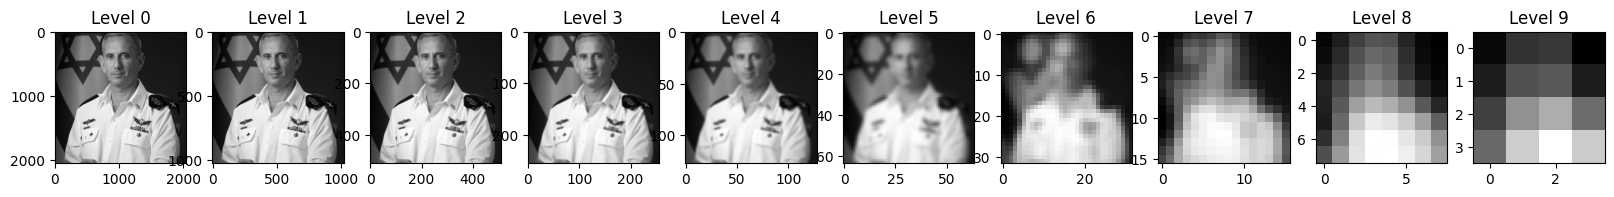

In [376]:
img = get_gray_img_mat('./assets/hagari.jpeg')
pyramid = create_pyramid(img, 9)
plot_pyramid(pyramid)

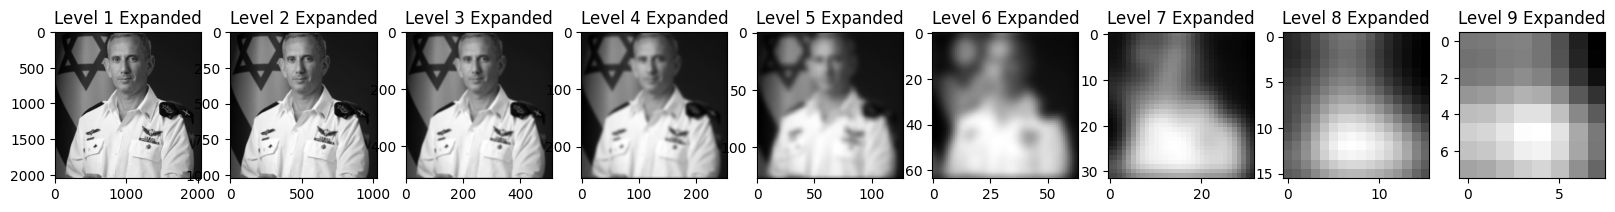

In [372]:
plot_expanded_pyramid(pyramid)

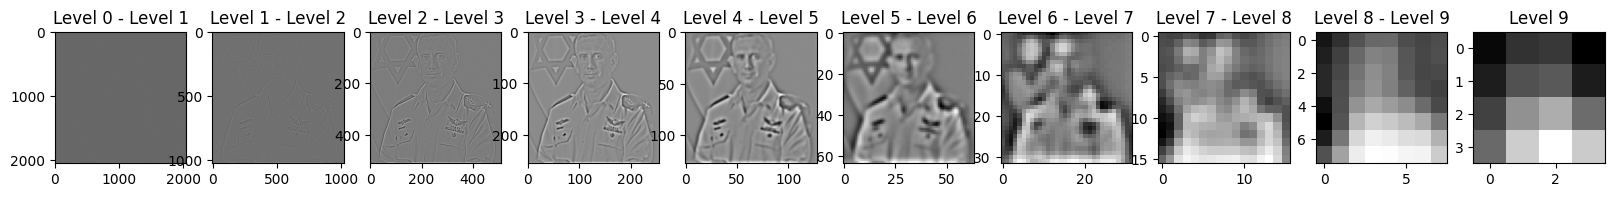

In [373]:
plot_pyramid_diff(pyramid)


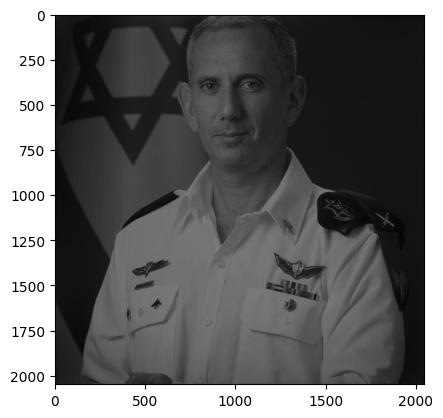

In [374]:
reconstructed_img = reconstruct_image(pyramid)
plt.imshow(reconstructed_img, cmap="gray")

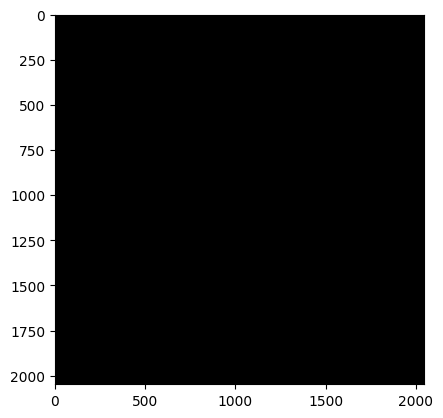

In [319]:
plt.imshow(img - reconstructed_img, cmap="gray")

In [379]:
img_1 = open_image('./assets/apple.jpeg')
img_2 = open_image('./assets/orange.jpeg')
mask = get_gray_img_mat('./assets/mask.jpeg')
blended_img = blend_images(img_1, img_2, mask, 8, kernel_size=9)

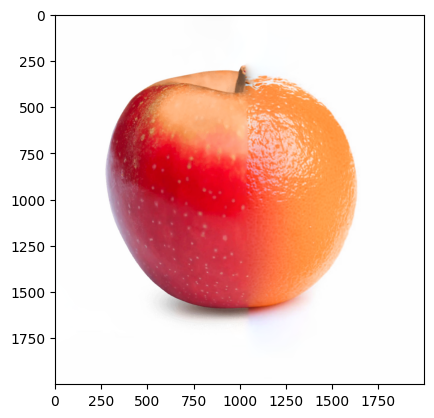

In [321]:
plt.imshow(blended_img)

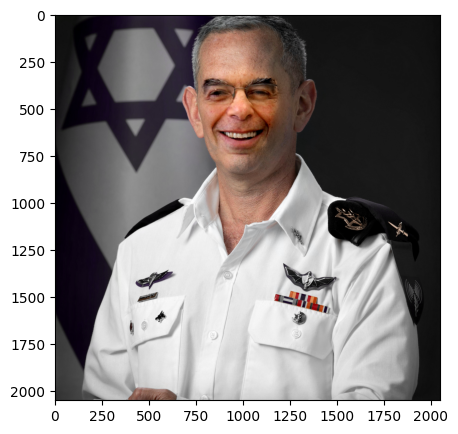

In [387]:
img1 = open_image('./assets/shmuel3.png')
img2 = open_image('./assets/hagari3.png')
mask= get_gray_img_mat('./assets/mask3.png')
blended_img = blend_images(img1, img2, mask, max_level=7, kernel_size=7)
plt.figure(figsize=(5, 5))  # Adjust the width and height as needed
plt.imshow(blended_img)

In [323]:
img_1 = get_gray_img_mat('./assets/Aligner_Monroe.jpg')
img_2 = get_gray_img_mat('./assets/Aligner_Einstein_BW.jpg')

pyramid1 = create_pyramid(img_1)
pyramid2 = create_pyramid(img_2)


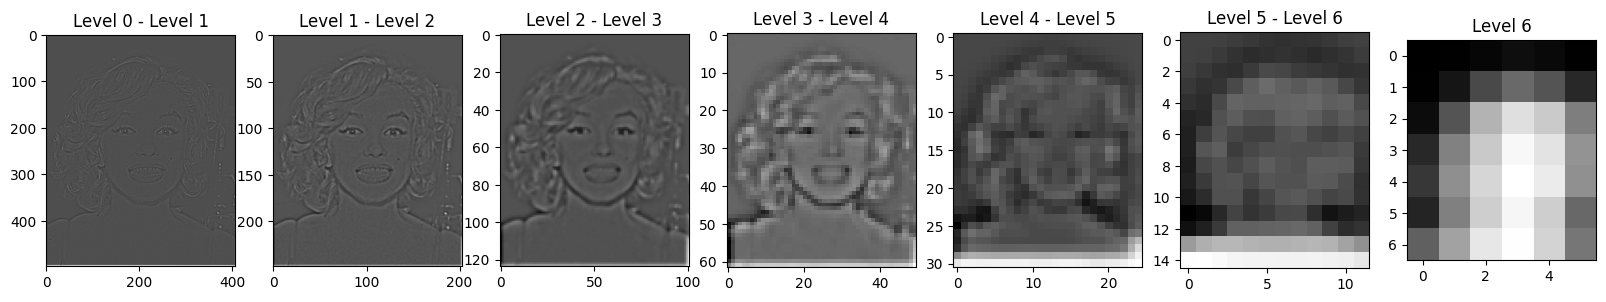

In [324]:
plot_pyramid_diff(pyramid1)

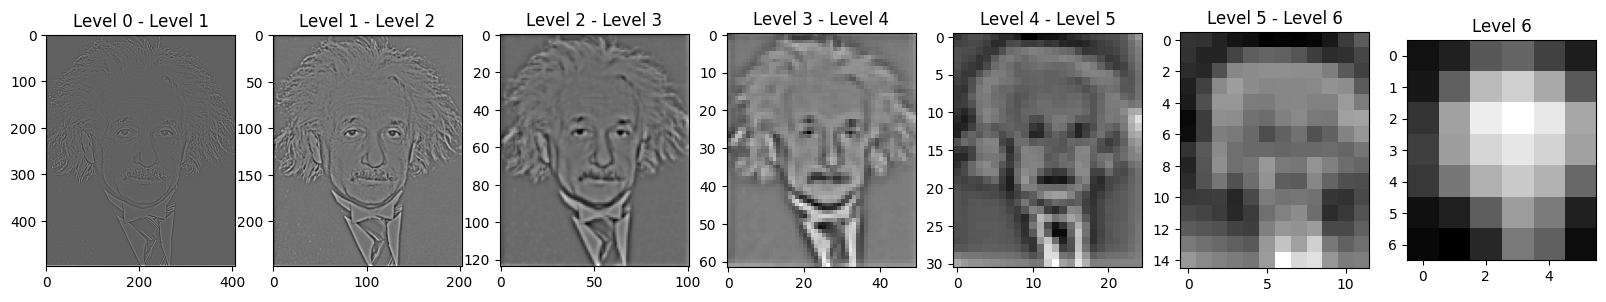

In [325]:
plot_pyramid_diff(pyramid2)

In [334]:
def blend_pyramids_based_on_level(pyramid1, pyramid2, max_level_1):
    blended_pyramid = []
    i = 0
    for i in range(max_level_1):
        blended_pyramid.append({'L': pyramid1[i]['L']})
    for i in range(max_level_1, len(pyramid1)):
        blended_pyramid.append({'L': pyramid2[i]['L']})
    return blended_pyramid

blended_pyramid = blend_pyramids_based_on_level(pyramid1, pyramid2, 3)

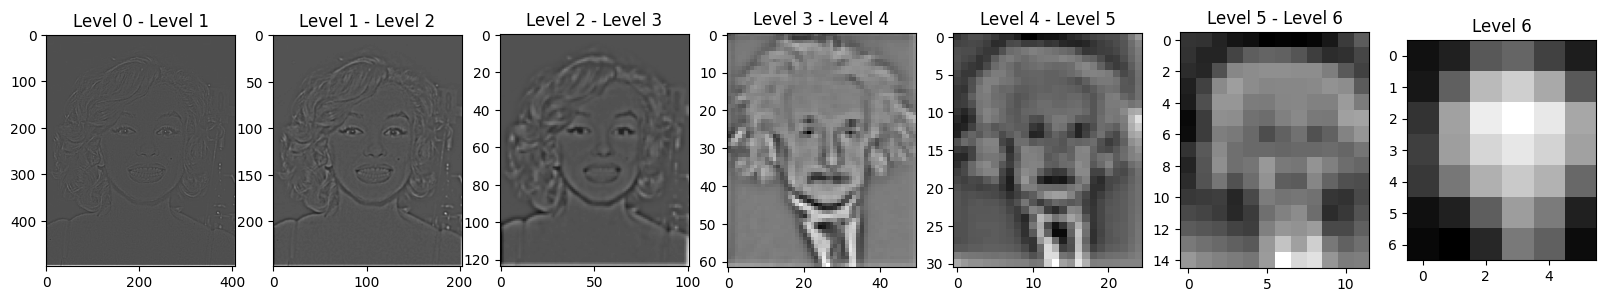

In [335]:
plot_pyramid_diff(blended_pyramid)

In [411]:
# sum everything up 
def q2(img_1_path, img_2_path, kernel_size=5, level = 2):
    img_1 = get_gray_img_mat(img_1_path)
    img_2 = get_gray_img_mat(img_2_path)
    pyramid1 = create_pyramid(img_1, kernel_size)
    pyramid2 = create_pyramid(img_2, kernel_size)
    blended_pyramid = blend_pyramids_based_on_level(pyramid1, pyramid2, level)
    reconstructed_img = reconstruct_image(blended_pyramid)
    return reconstructed_img



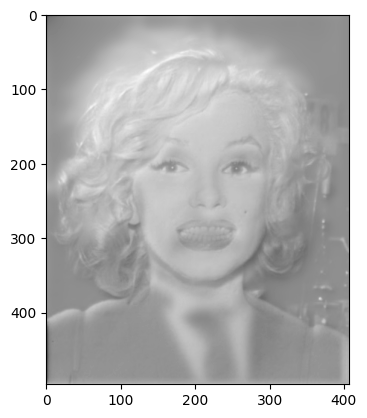

In [410]:
img_1_path = './assets/Aligner_Monroe.jpg'
img_2_path = './assets/Aligner_Einstein_BW.jpg'
reconstructed_img = q2(img_1_path, img_2_path, kernel_size=4, level=3)
plt.imshow(reconstructed_img, cmap="gray")

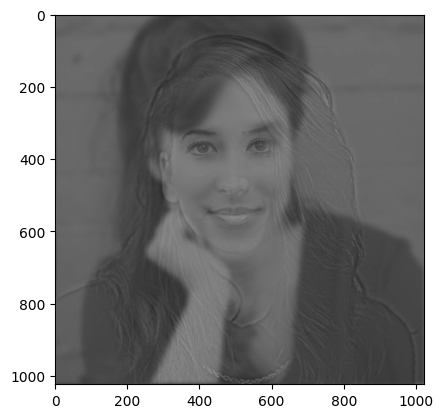

In [413]:
img_2_path = './assets/tutit4.png'
img_1_path = './assets/milel4.png'
reconstructed_img = q2(img_1_path, img_2_path, kernel_size=5, level=3)
plt.imshow(reconstructed_img, cmap="gray")

In [348]:

get_gaussian_kernel(9)

(array([[   1,    8,   28,   56,   70,   56,   28,    8,    1],
        [   8,   64,  224,  448,  560,  448,  224,   64,    8],
        [  28,  224,  784, 1568, 1960, 1568,  784,  224,   28],
        [  56,  448, 1568, 3136, 3920, 3136, 1568,  448,   56],
        [  70,  560, 1960, 3920, 4900, 3920, 1960,  560,   70],
        [  56,  448, 1568, 3136, 3920, 3136, 1568,  448,   56],
        [  28,  224,  784, 1568, 1960, 1568,  784,  224,   28],
        [   8,   64,  224,  448,  560,  448,  224,   64,    8],
        [   1,    8,   28,   56,   70,   56,   28,    8,    1]]),
 65536)